# Design and test a lowpass FIR filter

This document describes how to design a lowpass filter with a cutoff frequency $\omega_c$ and compute the discrete coefficients so that it can be implemented on hardware.

### 0. import library

In [1]:
# Packages and adjustments to the figures

#!pip install cmsisdsp

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import kaiserord, lfilter, firwin, freqz
import cmsisdsp as dsp 
import cmsisdsp.fixedpoint as f



## 1. Generate a test signal
 
* A simple test signal $\boldsymbol{y} = \{ y_i \}$ is generated with a fixed sampling frequency using the function:

$$y(t) = m_0 \sin(2\pi f_0 t) + m_1 \sin(2\pi f_1 t)$$

* The power spectrum is plotted as the magnitude of the discrete fourier transform (DFT): $|\hat{\boldsymbol{y}}|$

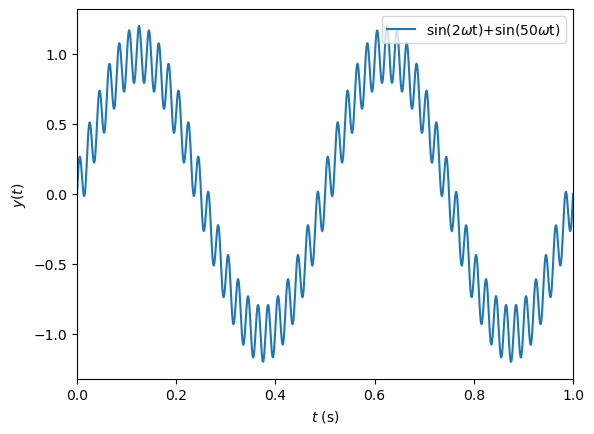

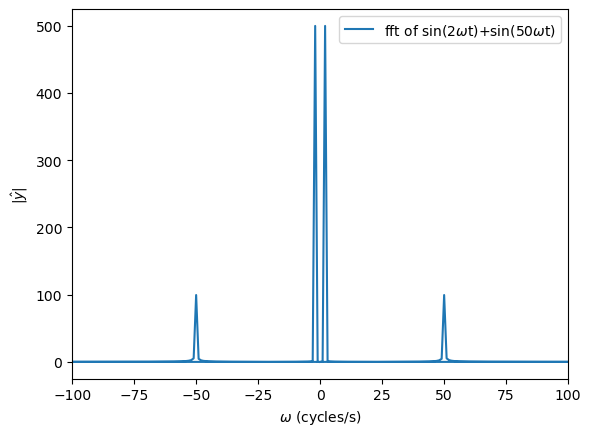

In [2]:
# Generate a signal
samplingFreq = 1000; # sampled at 1 kHz = 1000 samples / second
tlims = [0,1]        # in seconds
signalFreq = [2,50]; # Cycles / second
signalMag = [1,0.2]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
plt.figure()
plt.plot(t,y,label='sin(2$\omega$t)+sin(50$\omega$t)');
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");
plt.xlim([min(t),max(t)]);
plt.legend()
# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat),label='fft of sin(2$\omega$t)+sin(50$\omega$t)');
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");
plt.legend()

## 2. FIR Low-pass filter initialize cutoff_hz and ripple_db and window
### generate by scipy


In [3]:
# The Nyquist rate of the signal.
nyq_rate = samplingFreq / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 2.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 10.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 5.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
fir_filtered_y = lfilter(taps, 1.0, y)
print("number of taps (N) : ",N, "beta: ",beta, "width: ",width)


number of taps (N) :  73 beta:  0.0 width:  0.004


## 3. Low-pass FIR filter Frequency Response on scipy


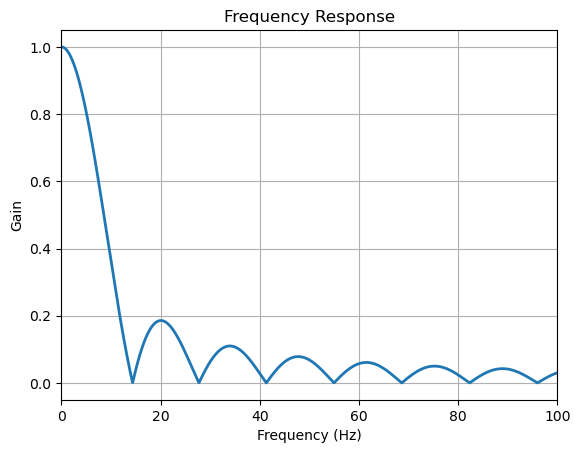

In [4]:
plt.figure()
plt.clf()
w, h = freqz(taps, worN=8000)
plt.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.xlim(0,100.0)
plt.ylim(-0.05, 1.05)
plt.grid(True)



## 4. FIR Low-pass filter generate by arm cmsis dsp


In [5]:
print("fir f32")

firf32 = dsp.arm_fir_instance_f32()
Y = [0 for X in range(len(y)+len(taps))]

dsp.arm_fir_init_f32(firf32,len(taps),taps,Y)

try:
    cmsis_filter = dsp.arm_fir_f32(firf32,y)
except Exception as e:
    print(e)


fir f32


5. Filter output on input signal

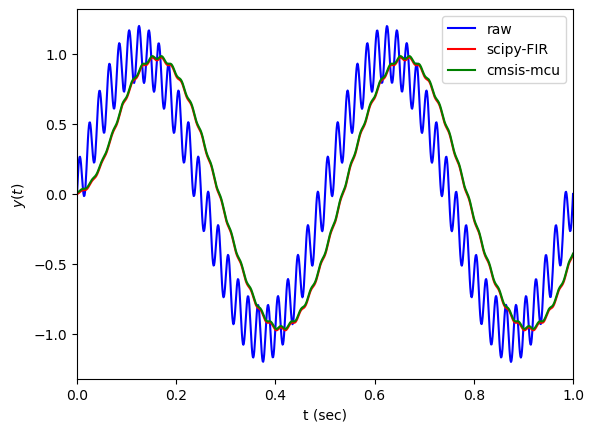

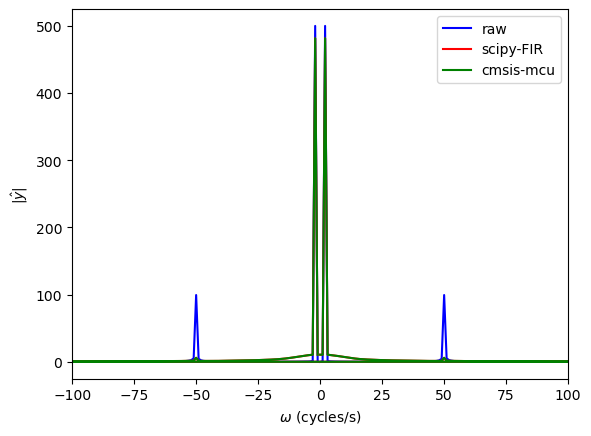

In [9]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)

small_offset = 0.01
# Plot the signal
plt.figure()
plt.plot(t,y,'b-',label='raw');
plt.plot(t,fir_filtered_y,'r-',label='scipy-FIR');
plt.plot(t,cmsis_filter+small_offset,'g-',label='cmsis-mcu')
plt.ylabel("$y(t)$")
plt.xlabel("t (sec)");
plt.xlim([min(t),max(t)]);
plt.legend()

# Generate Fourier transform
yfilthat_scipy = np.fft.fft(fir_filtered_y)
yfilthat_cmsis = np.fft.fft(fir_filtered_y)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fcycles,np.absolute(yhat),'b-',label='raw');
plt.plot(fcycles,np.absolute(yfilthat_scipy),'r-',label='scipy-FIR');
plt.plot(fcycles,np.absolute(yfilthat_cmsis)+small_offset,'g-',label='cmsis-mcu');
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");
plt.legend()


## 5. Filter coefficients an length


In [7]:
print("len taps:",len(taps))
taps

len taps: 73


array([0.01178717, 0.01193876, 0.01208714, 0.01223223, 0.01237393,
       0.01251217, 0.01264687, 0.01277794, 0.01290531, 0.01302892,
       0.01314868, 0.01326452, 0.01337638, 0.01348419, 0.0135879 ,
       0.01368743, 0.01378273, 0.01387374, 0.01396042, 0.0140427 ,
       0.01412055, 0.01419391, 0.01426274, 0.01432701, 0.01438666,
       0.01444168, 0.01449202, 0.01453766, 0.01457856, 0.01461471,
       0.01464608, 0.01467266, 0.01469443, 0.01471137, 0.01472348,
       0.01473075, 0.01473318, 0.01473075, 0.01472348, 0.01471137,
       0.01469443, 0.01467266, 0.01464608, 0.01461471, 0.01457856,
       0.01453766, 0.01449202, 0.01444168, 0.01438666, 0.01432701,
       0.01426274, 0.01419391, 0.01412055, 0.0140427 , 0.01396042,
       0.01387374, 0.01378273, 0.01368743, 0.0135879 , 0.01348419,
       0.01337638, 0.01326452, 0.01314868, 0.01302892, 0.01290531,
       0.01277794, 0.01264687, 0.01251217, 0.01237393, 0.01223223,
       0.01208714, 0.01193876, 0.01178717])

## 6. mean and variance raw singal and  FIR output


In [8]:


print("sin noisy mean: ",y.mean())
print("sin noisy var: " ,y.var())
print("fir mean: ",fir_filtered_y.mean() )
print("fir var: ", fir_filtered_y.var())

sin noisy mean:  0.0
sin noisy var:  0.51948
fir mean:  0.010776961394674657
fir var:  0.465838732679487
